In [198]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import scipy.stats
import statsmodels.formula.api as smf
%matplotlib inline

In [199]:
msc_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/MSC_data/'
home_dir = '/home/despo/iballard/lags/'
subs = ['sub-MSC01',
        'sub-MSC02',
        'sub-MSC03',
        'sub-MSC04',
        'sub-MSC05',
        'sub-MSC06',
        'sub-MSC07',
        'sub-MSC08',
        'sub-MSC09']

mean_lag_map_dir = op.join(home_dir,
                           'MSC_mean_lags')
if not op.exists(mean_lag_map_dir):
    os.mkdir(mean_lag_map_dir)

In [82]:
##downsample to 3x3x3
for sub in subs:
    
    out_dir = op.join(mean_lag_map_dir,
                     sub)
    
    if not op.exists(out_dir):
        os.mkdir(out_dir)
    
    mask =  op.join(msc_dir,
                 'fmriprep',
                 sub,
                'ses-func01', 
                 'func',
                 sub + '_ses-func01_task-rest_space-T1w_desc-brain_mask.nii.gz')
     

    out_f_resample = op.join(out_dir,
                             'brain_mask_func_space_spline.nii.gz')

    cmd = ['flirt',
       '-applyisoxfm',
        '3',
       '-usesqform',
       '-in',
      mask,
       '-ref',
       mask,
        '-out',
       out_f_resample,
      '-interp',
      'linear']
    
    os.system(' '.join(cmd))
    
    out_f_thresh = op.join(out_dir,
                             'brain_mask_func_space.nii.gz')
    cmd = ['fslmaths',
          out_f_resample,
          '-thr',
           '.5',
          '-bin',
          out_f_thresh]
    os.system(' '.join(cmd))
    
#     os.remove(out_f_resample)

In [201]:
##make mean lag maps for each subject
for sub in subs:
    
    out_dir = op.join(mean_lag_map_dir,
                     sub)
    if not op.exists(out_dir):
        os.mkdir(out_dir)
    

    lag_maps = glob.glob(op.join(msc_dir,
                                 'lags',
                                sub,
                                'ses-func_Nov24_reslice*',
                                sub +'__lagtimes.nii.gz'))
    mask =  op.join(out_dir,
                             'brain_mask_func_space')

    out_f = op.join(out_dir,
                   sub + '_mean_lag_map')
    
    cmd = ['fslmaths',
          lag_maps[0]]
    
    for n,lag in enumerate(lag_maps):
        if n > 0:
            cmd.append('-add')
            cmd.append(lag)
        
    cmd.append('-mul')
    cmd.append(str(1.0/len(lag_maps)))
    cmd.append('-mul')
    cmd.append(mask)
    cmd.append(out_f)
    os.system(' '.join(cmd))

In [83]:
#mask T1s
for sub in subs:
    
    out_dir = op.join(mean_lag_map_dir,
                     sub)
    t1  = op.join(msc_dir,
                 'fmriprep',
                 sub,
                 'anat',
                 sub + '_desc-preproc_T1w.nii.gz')
    
    mask =  op.join(msc_dir,
                 'fmriprep',
                 sub,
                 'anat',
                 sub + '_desc-brain_mask.nii.gz')

    out_f = op.join(out_dir,
                   sub + '_T1w')
    
    cmd = ['fslmaths',
          t1,
          '-mul',
          mask,
          out_f]
    
    os.system(' '.join(cmd))

In [3]:
angio_thres = {'sub-MSC01':4,
        'sub-MSC02':4,
        'sub-MSC03':5.5,
        'sub-MSC04':6,
        'sub-MSC05':4.5,
        'sub-MSC06':4.5,
        'sub-MSC07':5,
        'sub-MSC08':5,
        'sub-MSC09':4.5}

In [95]:
#mask angios
for sub in subs:
    
    out_dir = op.join(mean_lag_map_dir,
                     sub)
    
    #thresshold angio
    out_f_thresh = op.join(out_dir,
                   sub + '_angio_thresh_anat_res.nii.gz')
    angio  = op.join(msc_dir,
                 'angios',
                 sub,
                 'reg',
                 'angio_to_t1_Warped.nii.gz')
    
    cmd = ['fslmaths',
          angio,
           '-thr',
           str(angio_thres[sub]),
           '-bin',
          out_f_thresh] 
    os.system(' '.join(cmd))
    
    #resample to func space
    out_f_func_space = op.join(out_dir,
                   sub + '_angio_3mm.nii.gz')

    #threshold resampled mask
    brain_mask =  op.join(out_dir,
                             'brain_mask_func_space')  
    
    cmd = ['flirt',
       '-applyisoxfm',
        '3',
       '-usesqform',
       '-in',
      out_f_thresh,
       '-ref',
       brain_mask,
        '-out',
       out_f_func_space,
      '-interp',
      'spline']
    
    os.system(' '.join(cmd))
     
    #threshold and mask
    out_f_new = op.join(out_dir,
                   sub + '_angio_unsmoothed.nii.gz')        

    cmd = ['fslmaths',
          out_f_func_space,
           '-thr',
           '.2',
           '-bin',
          '-mul',
          brain_mask,
          out_f_new] 
    
    os.system(' '.join(cmd))
    
    #threshold, mask, and smooth
    out_f_new = op.join(out_dir,
                   sub + '_angio_smoothed.nii.gz')        
    cmd = ['fslmaths',
          out_f_func_space,
           '-thr',
           '.2',
           '-s',
           '4.26', #10mm smoothing
          '-mul',
          brain_mask,
          out_f_new] 
    
    os.system(' '.join(cmd))

In [5]:
veno_thres = {'sub-MSC01':4,
        'sub-MSC02':4,
        'sub-MSC03':5.5,
        'sub-MSC04':6,
        'sub-MSC05':4.5,
        'sub-MSC06':4.5,
        'sub-MSC07':5,
        'sub-MSC08':5,
        'sub-MSC09':4.5}

In [96]:
#mask venos
for sub in subs:
    
    out_dir = op.join(mean_lag_map_dir,
                     sub)
    
    out_f_thresh = op.join(out_dir,
                   sub + '_veno_thresh_anat_res.nii.gz')
    veno  = op.join(msc_dir,
                 'venos',
                 sub,
                     '2',
                 'reg',
                     '2',
                 'veno_to_t1_Warped.nii.gz')
    
    
    cmd = ['fslmaths',
          veno,
           '-thr',
           str(veno_thres[sub]),
           '-bin',
          out_f_thresh] 
    os.system(' '.join(cmd))
    
    
    out_f_func_res = op.join(out_dir,
                   sub + '_veno_3mm.nii.gz')

    #threshold resampled mask
    brain_mask =  op.join(out_dir,
                             'brain_mask_func_space')  
    
    cmd = ['flirt',
       '-applyisoxfm',
        '3',
       '-usesqform',
       '-in',
      out_f_thresh,
       '-ref',
       brain_mask,
        '-out',
       out_f_func_res,
      '-interp',
      'spline']
    
    os.system(' '.join(cmd))
    
     
    out_f_new = op.join(out_dir,
                   sub + '_veno_unsmoothed.nii.gz')        

    cmd = ['fslmaths',
          out_f_func_res,
           '-thr',
           '.2',
           '-bin',
          '-mul',
          brain_mask,
          out_f_new] 
    
    os.system(' '.join(cmd))

    
    out_f_new = op.join(out_dir,
                   sub + '_veno_smoothed.nii.gz')        

    cmd = ['fslmaths',
          out_f_func_res,
           '-thr',
           '.2',
           '-s',
           '4.26', #10mm smoothing
            '-mul',
          brain_mask,
          out_f_new] 
    
    os.system(' '.join(cmd))


## Mask processing

In [272]:
#process white matter masks
for sub in subs:
    out_dir = op.join(mean_lag_map_dir,
                     sub)

    #threshold resampled mask
    brain_mask =  op.join(out_dir,
                             'brain_mask_func_space.nii.gz') 
    
    wm = op.join(msc_dir,
                      'fmriprep',
                      sub,
                        'anat',
                      sub + '_label-WM_probseg.nii.gz')
    
    out_f_resample = op.join(out_dir,
                            'masks',
                            'wm_func_res')
    cmd = ['flirt',
       '-applyisoxfm',
        '3',
       '-usesqform',
       '-in',
      wm,
       '-ref',
       brain_mask,
        '-out',
       out_f_resample,
      '-interp',
      'spline']
    os.system(' '.join(cmd))
    
    
    bin_out =  op.join(out_dir,
                          'masks',
                          'wm_bin_func_res.nii.gz')
    cmd = ['fslmaths',
          out_f_resample,
           '-thr',
           '.95',
           '-bin',
            '-mul',
           brain_mask,
            bin_out]
    os.system(' '.join(cmd))
        
    smooth_out =  op.join(out_dir,
                          'masks',
                          'wm_smoothed_func_res.nii.gz')
    cmd = ['fslmaths',
          bin_out,
           '-s',
            '4.26', #10mm smoothing
            '-mul',
           brain_mask,
            smooth_out]
    os.system(' '.join(cmd))

In [99]:
from skimage.morphology import ball
#process deep white matter masks
for sub in subs:
    out_dir = op.join(mean_lag_map_dir,
                     sub)

    ###copied from fmriprep: https://github.com/nipreps/fmriprep/blob/b6c7b953bb0a07fe466aed556a21ed02ae218da5/fmriprep/utils/confounds.py#L145 
    wm_out =  op.join(out_dir,
                          'masks',
                          'deep_wm_anat_res.nii.gz')
    
    wm = nb.load(op.join(msc_dir,
                      'fmriprep',
                      sub,
                        'anat',
                      sub + '_label-WM_probseg.nii.gz'))
    wm_data = wm.get_fdata()
    
    gm = nb.load(op.join(msc_dir,
                      'fmriprep',
                      sub,
                        'anat',
                      sub + '_label-GM_probseg.nii.gz'))
    gm_data = gm.get_fdata() > 0.05
    
    str_mask = nb.load(op.join(msc_dir,
                      'native_masks',
                      sub,
                      sub + '_striatum_mask_nn_in_t1_space.nii.gz'))
    str_data = str_mask.get_fdata() > 0

    #dilate striatum mask
    str_data = scipy.ndimage.binary_dilation(str_data, structure=ball(2.5))

    ##mask out striatum from GM
    gm_data[str_data] = 0
    
    # Dilate the GM mask
    gm_data = scipy.ndimage.binary_dilation(gm_data, structure=ball(2.5))

    
    wm_data[gm_data] = 0  # Make sure voxel does not contain GM
    
    
    nb.Nifti1Image(wm_data, gm.affine, gm.header).to_filename(wm_out)
    
    

    #threshold resampled mask
    brain_mask =  op.join(out_dir,
                             'brain_mask_func_space.nii.gz') 
    out_f_resample = op.join(out_dir,
                            'masks',
                            'deep_wm_func_res')
    cmd = ['flirt',
       '-applyisoxfm',
        '3',
       '-usesqform',
       '-in',
      wm_out,
       '-ref',
       brain_mask,
        '-out',
       out_f_resample,
      '-interp',
      'spline']
    os.system(' '.join(cmd))
    

        
    smooth_out =  op.join(out_dir,
                          'masks',
                          'deep_wm_smoothed_func_res.nii.gz')
    cmd = ['fslmaths',
          out_f_resample,
           '-s',
            '4.26', #10mm smoothing
            '-mul',
           brain_mask,
            smooth_out]
    os.system(' '.join(cmd))

In [89]:
for sub in subs:
    
    mask_dir = op.join(mean_lag_map_dir,
                     sub,
                      'masks')
    
    if not op.exists(mask_dir):
        os.mkdir(mask_dir)
        
    
    striatum = op.join(msc_dir,
                      'native_masks',
                      sub,
                      sub + '_striatum_mask_spline_in_T1_space.nii.gz')
    
    
    mask =  op.join(msc_dir,
                 'fmriprep',
                 sub,
                 'anat',
                 sub + '_desc-brain_mask.nii.gz')
    
    out_f = op.join(mask_dir,
                   'anat_mask_minus_striatum_T1_res.nii.gz')
        
    cmd = ['fslmaths',
          striatum,
           '-thr',
           '.1',
           '-bin',
          '-mul',
          '-1',
          '-add',
          mask,
          out_f]
    os.system(' '.join(cmd))


In [273]:
for sub in subs:
    

    mask_dir = op.join(mean_lag_map_dir,
                     sub,
                      'masks')
    out_dir = op.join(mean_lag_map_dir,
                     sub)
    func_mask =  op.join(out_dir,
                             'brain_mask_func_space')
    for mask in ['nacc','putamen','caudate','striatum_mask','ventricles','HCP_lag']:
        
        if mask != 'ventricles':
            
            roi = op.join(msc_dir,
                              'native_masks',
                              sub,
                              sub + '_' + mask + '_reslice_spline_in_func_space.nii.gz') 
        else:
            roi = op.join(msc_dir,
                              'native_masks',
                              sub,
                              sub + '_' + mask + '_spline_in_func_space.nii.gz') 

        out_roi = op.join(mask_dir,
                          mask + '_func_res.nii.gz')
        
        out_f_nacc= op.join(mask_dir,
                          'brain_mask_minus_nacc_func_res.nii.gz')
            
        if mask == 'nacc':
            cmd = ['fslmaths',
                  roi,
                   '-thr',
                   '.4',
                   '-bin',
                   out_roi]
        elif mask == 'striatum_mask':
            cmd = ['fslmaths',
                  roi,
                   '-thr',
                   '.3',
                   '-bin',
                   out_roi]
        elif mask == 'ventricles':
            cmd = ['fslmaths',
                  roi,
                   '-thr',
                   '.3',
                   '-bin',
                   out_roi]
        elif mask == 'HCP_lag':
            cmd = ['fslmaths',
                  roi,
                   '-mul',
                   func_mask,
                   out_roi]
        else: #cross out nacc overlap
            cmd = ['fslmaths',
                  roi,
                   '-thr',
                   '.3',
                   '-bin',
                   '-mul',
                   out_f_nacc,
                   out_roi] 
        os.system(' '.join(cmd))
        

        if mask == 'nacc':
            
            
            out_nacc = op.join(mask_dir,
                          'nacc_func_res.nii.gz')
            cmd = ['fslmaths',
                   out_nacc,
                  '-mul',
                  '-1',
                  '-add',
                  func_mask,
                  out_f_nacc]
            os.system(' '.join(cmd))
         
        
        if mask == 'ventricles': #smooth ventricles
            smooth_out =  op.join(mask_dir,
                          mask + '_smoothed_func_res.nii.gz')
            cmd = ['fslmaths',
                  out_roi,
                   '-mul',
                   func_mask,
                   '-s',
                    '4.26', #10mm smoothing
                    smooth_out]
            os.system(' '.join(cmd))

        if mask == 'HCP_lag':
            wm_mask = op.join(mask_dir,
                          'wm_bin_func_res.nii.gz')
            smooth_wm_out = op.join(mask_dir,
                          mask + '_wm_mask_smoothed_func_res.nii.gz')
            cmd = ['fslmaths',
                  out_roi,
                   '-mul',
                   wm_mask,
                   '-s',
                    '4.26', #10mm smoothing
                    smooth_wm_out]
            os.system(' '.join(cmd))    

            ventricle_mask = op.join(mask_dir,
                          'ventricles_func_res.nii.gz')
            smooth_ventricle_out = op.join(mask_dir,
                          mask + '_ventricles_mask_smoothed_func_res.nii.gz')
            cmd = ['fslmaths',
                  out_roi,
                   '-mul',
                   wm_mask,
                   '-s',
                    '4.26', #10mm smoothing
                    smooth_ventricle_out]
            os.system(' '.join(cmd))
            
            angio_mask = op.join(mean_lag_map_dir,
                             sub,
                          sub + '_angio_unsmoothed.nii.gz')
            smooth_angio_out = op.join(mask_dir,
                          mask + '_angio_mask_smoothed_func_res.nii.gz')
            cmd = ['fslmaths',
                  out_roi,
                   '-mul',
                   angio_mask,
                   '-s',
                    '4.26', #10mm smoothing
                    smooth_angio_out]
            os.system(' '.join(cmd))
            
            veno_mask = op.join(mean_lag_map_dir,
                             sub,
                          sub + '_veno_unsmoothed.nii.gz')
            smooth_veno_out = op.join(mask_dir,
                          mask + '_veno_mask_smoothed_func_res.nii.gz')
            cmd = ['fslmaths',
                  out_roi,
                   '-mul',
                   veno_mask,
                   '-s',
                    '4.26', #10mm smoothing
                    smooth_veno_out]
            os.system(' '.join(cmd))

In [51]:
for sub in subs:
    mask_dir = op.join(mean_lag_map_dir,
                     sub,
                      'masks')
    for mask in ['caudate','putamen']:

        roi = op.join(mask_dir,
                              mask + '_func_res.nii.gz')
        for dilation in range(4):

            nacc_orig = op.join(mask_dir,
                                  'nacc_func_res.nii.gz')
            if dilation == 0:
                nacc = op.join(mask_dir,
                                  'nacc_func_res.nii.gz')
                brain_minus_nacc= op.join(mask_dir,
                              'brain_mask_minus_nacc_func_res.nii.gz')

            else:
                nacc = op.join(mask_dir,
                                  'nacc_dil' + str(dilation) + '_' + mask +  '_func_res.nii.gz')
                brain_minus_nacc= op.join(mask_dir,
                              'brain_mask_minus_nacc_dil' + str(dilation) + '_' + mask +  '_func_res.nii.gz')


            out_f = op.join(mask_dir,
                                  'nacc_dil' + str(dilation+1) + '_' + mask +  '_func_res.nii.gz')

            #dilate NAcc within caudate or putamen
            cmd = ['fslmaths',
                  nacc_orig]
            for i in range(dilation+1):
                cmd.append('-dilD')

            cmd.append('-mul')        
            cmd.append(roi)
            cmd.append('-mul')        
            cmd.append(brain_minus_nacc)   
            cmd.append(out_f)
            os.system(' '.join(cmd))

            #create new dilated subtraction mask
            out_mask = op.join(mask_dir,
                              'brain_mask_minus_nacc_dil' + str(dilation+1) + '_' + mask +  '_func_res.nii.gz')
            cmd = ['fslmaths',
                  out_f,
                  '-mul',
                  '-1',
                  '-add',
                  brain_minus_nacc,
                   out_mask
                  ]
            os.system(' '.join(cmd))


## Load data

/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


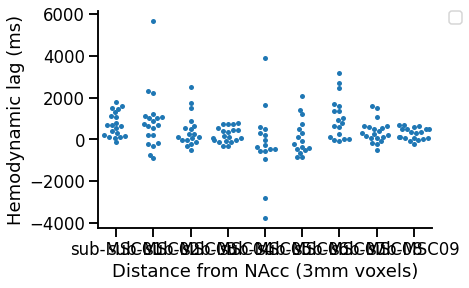

In [329]:
nacc = df[df['mask'] == 'nacc']
nacc = df[df['mask'] == 'nacc']
sns.set_context('talk')
sns.swarmplot(x = 'sub',
             y = 'lag',
              dodge = .1,
#               units = 'sub',
             data = nacc)
sns.despine()
plt.ylabel('Hemodynamic lag (ms)')
plt.xlabel('Distance from NAcc (3mm voxels)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


## Regression analysis

In [328]:
for sub in subs:
    
    out_f = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_lag_map_resid_hcp.nii.gz')
    
    angio_data = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_angio_unsmoothed.nii.gz')
    angio_data = nb.load(angio_data).get_fdata()
    
    angio_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                        'masks',
                      'HCP_lag_angio_mask_smoothed_func_res.nii.gz')
    angio_data_hcp = nb.load(angio_data_hcp).get_fdata()
    
    
    angio_data_s = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_angio_smoothed.nii.gz')
    angio_data_s = nb.load(angio_data_s).get_fdata()
    
            
    veno_data = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_veno_unsmoothed.nii.gz')
    veno_data = nb.load(veno_data).get_fdata()

    veno_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                    'HCP_lag_veno_mask_smoothed_func_res.nii.gz')
    veno_data_hcp = nb.load(veno_data_hcp).get_fdata()
    
    veno_data_s = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_veno_smoothed.nii.gz')
    veno_data_s = nb.load(veno_data_s).get_fdata()
    
    lag_map = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_mean_lag_map.nii.gz')
    lag_map = nb.load(lag_map)
    lag_data = lag_map.get_fdata()    
    
#     mask = lag_data!=0
    
    mask = op.join(mean_lag_map_dir,
                     sub,
                      'brain_mask_func_space.nii.gz')
    mask = nb.load(mask).get_fdata().astype(bool)
    
    
    ventricle_data = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'ventricles_smoothed_func_res.nii.gz')
    ventricle_data = nb.load(ventricle_data).get_fdata()

    ventricle_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                    'HCP_lag_ventricles_mask_smoothed_func_res.nii.gz')
    ventricle_data_hcp = nb.load(ventricle_data_hcp).get_fdata()
    
    ventricle_data_unsmoothed = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'ventricles_func_res.nii.gz')
    ventricle_data_unsmoothed = nb.load(ventricle_data_unsmoothed).get_fdata()
    
    wm_data = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'wm_smoothed_func_res.nii.gz')
    wm_data = nb.load(wm_data).get_fdata()
  
    wm_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'HCP_lag_wm_mask_smoothed_func_res.nii.gz')
    wm_data_hcp = nb.load(wm_data_hcp).get_fdata()

    deep_wm_data = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'deep_wm_smoothed_func_res.nii.gz')
    deep_wm_data = nb.load(deep_wm_data).get_fdata()

    wm_data_unsmoothed = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'wm_func_res.nii.gz')
    wm_data_unsmoothed = nb.load(wm_data_unsmoothed).get_fdata()
    
    sub_df = pd.DataFrame({'lags':lag_data[mask],
                          'veno_us':veno_data[mask],
                          'veno_hcp':veno_data_hcp[mask],
                           'veno':veno_data_s[mask],
                            'ventricle':ventricle_data[mask],
                           'ventricle_hcp':ventricle_data_hcp[mask],
                           'ventricle_us':ventricle_data_unsmoothed[mask],
                           'wm':wm_data[mask],
                           'wm_hcp':wm_data_hcp[mask],
                           'wm_us':wm_data_unsmoothed[mask],
                           'deep_wm':deep_wm_data[mask],
                          'angio_us':angio_data[mask],
                            'angio_hcp':angio_data_hcp[mask],
                          'angio':angio_data_s[mask]})
        
    sub_df['veno'] = sub_df['veno'] - np.mean(sub_df['veno'])
    sub_df['veno_us'] = sub_df['veno_us'] - np.mean(sub_df['veno_us'])
    sub_df['veno_hcp'] = sub_df['veno_hcp'] - np.mean(sub_df['veno_hcp'])
    sub_df['angio'] = sub_df['angio'] - np.mean(sub_df['angio'])
    sub_df['angio_us'] = sub_df['angio_us'] - np.mean(sub_df['angio_us'])
    sub_df['angio_hcp'] = sub_df['angio_hcp'] - np.mean(sub_df['angio_hcp'])
    sub_df['ventricle'] = sub_df['ventricle'] - np.mean(sub_df['ventricle'])
    sub_df['ventricle_hcp'] = sub_df['ventricle_hcp'] - np.mean(sub_df['ventricle_hcp'])
    sub_df['ventricle_us'] = sub_df['ventricle_us'] - np.mean(sub_df['ventricle_us'])
    sub_df['wm'] = sub_df['wm'] - np.mean(sub_df['wm'])
    sub_df['wm_hcp'] = sub_df['wm_hcp'] - np.mean(sub_df['wm_hcp'])
    sub_df['wm_us'] = sub_df['wm_us'] - np.mean(sub_df['wm_us'])
    sub_df['deep_wm'] = sub_df['deep_wm'] - np.mean(sub_df['deep_wm'])

    mod = smf.ols('lags ~ veno + veno_us + angio + angio_us + ventricle + ventricle_us + wm_us + wm +wm_hcp + ventricle_hcp+ angio_hcp + veno_hcp + I(veno**2) +  I(angio**2) +I(ventricle**2) +I(ventricle_hcp**2)+ I(wm**2) + I(wm_hcp**2) +  I(veno_hcp**2) + I(angio_hcp**2)',
       data = sub_df).fit()
    print(mod.summary())
    out_data = np.zeros(lag_data.shape) # initialize
    out_data[mask] = mod.resid
    
    img = nb.Nifti1Image(out_data,
                         lag_map.affine,
                         lag_map.header)


    nb.save(img,
        out_f)
    
    

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     1782.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:31:06   Log-Likelihood:                -72328.
No. Observations:               62978   AIC:                         1.447e+05
Df Residuals:                   62959   BIC:                         1.449e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.09

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     3088.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:31:07   Log-Likelihood:                -36436.
No. Observations:               52470   AIC:                         7.291e+04
Df Residuals:                   52451   BIC:                         7.308e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.32

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     2347.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:31:09   Log-Likelihood:                -79967.
No. Observations:               59134   AIC:                         1.600e+05
Df Residuals:                   59115   BIC:                         1.601e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.22

In [59]:
df = []
for sub in subs:
    

    mask_dir = op.join(mean_lag_map_dir,
                     sub,
                      'masks')
    
    art_data = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_angio.nii.gz')
    art_data = nb.load(art_data).get_fdata()
    
    mask_ids = {'nacc':0,
            'dil1':1,
            'dil2':2,
            'dil3':3,
            }
    masks = {}
    for mask in mask_ids.keys():
        if 'nacc' in mask:
            masks[mask] = nb.load(op.join(mask_dir,
                                mask + '_func_res.nii.gz')).get_fdata().astype(bool)
        else:
            
            
            caud = nb.load(op.join(mask_dir,
                                'nacc_'+ mask + '_caudate_func_res.nii.gz')).get_fdata().astype(bool)
            put = nb.load(op.join(mask_dir,
                                'nacc_'+ mask + '_putamen_func_res.nii.gz')).get_fdata().astype(bool)
            
            masks[mask] = np.logical_or(caud, put)
            
    lag_map = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_lag_map_resid.nii.gz')
    
        
    lags = nb.load(lag_map).get_fdata()
        
    for mask in mask_ids.keys():


        median= np.median(lags[masks[mask]])

        art_mean = art_data[masks[mask]].mean()


        sub_df = pd.DataFrame({'sub':sub,
                              'mask':mask,
                              'lag':median*1000,
                               'artery':art_mean,
                               'distance':mask_ids[mask]
                              }, index = [0])
        df.append(sub_df)     

df = pd.concat(df)

In [300]:
def remove_noise(lag_data, sub, mean_lag_map_dir):
    
    angio_data = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_angio_unsmoothed.nii.gz')
    angio_data = nb.load(angio_data).get_fdata()

    angio_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                        'masks',
                      'HCP_lag_angio_mask_smoothed_func_res.nii.gz')
    angio_data_hcp = nb.load(angio_data_hcp).get_fdata()
    
    angio_data_s = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_angio_smoothed.nii.gz')
    angio_data_s = nb.load(angio_data_s).get_fdata()
    
            
    veno_data = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_veno_unsmoothed.nii.gz')
    veno_data = nb.load(veno_data).get_fdata()
   

    veno_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                    'HCP_lag_veno_mask_smoothed_func_res.nii.gz')
    veno_data_hcp = nb.load(veno_data_hcp).get_fdata()    
    
    veno_data_s = op.join(mean_lag_map_dir,
                     sub,
                      sub + '_veno_smoothed.nii.gz')
    veno_data_s = nb.load(veno_data_s).get_fdata()
   
    mask = op.join(mean_lag_map_dir,
                     sub,
                      'brain_mask_func_space.nii.gz')
    mask = nb.load(mask).get_fdata().astype(bool)
    
    ventricle_data = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'ventricles_smoothed_func_res.nii.gz')
    ventricle_data = nb.load(ventricle_data).get_fdata()
    
    ventricle_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                    'HCP_lag_ventricles_mask_smoothed_func_res.nii.gz')
    ventricle_data_hcp = nb.load(ventricle_data_hcp).get_fdata()
    
    ventricle_data_unsmoothed = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'ventricles_func_res.nii.gz')
    ventricle_data_unsmoothed = nb.load(ventricle_data_unsmoothed).get_fdata()
    
    wm_data = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'wm_smoothed_func_res.nii.gz')
    wm_data = nb.load(wm_data).get_fdata()

    deep_wm_data = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'deep_wm_smoothed_func_res.nii.gz')
    deep_wm_data = nb.load(deep_wm_data).get_fdata()
    
    wm_data_hcp = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'HCP_lag_wm_mask_smoothed_func_res.nii.gz')
    wm_data_hcp = nb.load(wm_data_hcp).get_fdata()
    
    wm_data_unsmoothed = op.join(mean_lag_map_dir,
                     sub,
                    'masks',
                      'wm_func_res.nii.gz')
    wm_data_unsmoothed = nb.load(wm_data_unsmoothed).get_fdata()
    
    

     
    sub_df = pd.DataFrame({'lags':lag_data[mask],
                          'veno_us':veno_data[mask],
                          'veno_hcp':veno_data_hcp[mask],
                           'veno':veno_data_s[mask],
                            'ventricle':ventricle_data[mask],
                           'ventricle_hcp':ventricle_data_hcp[mask],
                           'ventricle_us':ventricle_data_unsmoothed[mask],
                           'wm':wm_data[mask],
                           'wm_hcp':wm_data_hcp[mask],
                           'wm_us':wm_data_unsmoothed[mask],
                           'deep_wm':deep_wm_data[mask],
                          'angio_us':angio_data[mask],
                            'angio_hcp':angio_data_hcp[mask],
                          'angio':angio_data_s[mask]})
       
    
    sub_df['veno'] = sub_df['veno'] - np.mean(sub_df['veno'])
    sub_df['veno_hcp'] = sub_df['veno_hcp'] - np.mean(sub_df['veno_hcp'])
    sub_df['veno_us'] = sub_df['veno_us'] - np.mean(sub_df['veno_us'])
    sub_df['angio'] = sub_df['angio'] - np.mean(sub_df['angio'])
    sub_df['angio_hcp'] = sub_df['angio_hcp'] - np.mean(sub_df['angio_hcp'])
    sub_df['angio_us'] = sub_df['angio_us'] - np.mean(sub_df['angio_us'])
    sub_df['ventricle'] = sub_df['ventricle'] - np.mean(sub_df['ventricle'])
    sub_df['ventricle_hcp'] = sub_df['ventricle_hcp'] - np.mean(sub_df['ventricle_hcp'])
    sub_df['ventricle_us'] = sub_df['ventricle_us'] - np.mean(sub_df['ventricle_us'])
    sub_df['wm'] = sub_df['wm'] - np.mean(sub_df['wm'])
    sub_df['wm_hcp'] = sub_df['wm_hcp'] - np.mean(sub_df['wm_hcp'])
    sub_df['wm_us'] = sub_df['wm_us'] - np.mean(sub_df['wm_us'])
    sub_df['deep_wm'] = sub_df['deep_wm'] - np.mean(sub_df['deep_wm'])

    mod = smf.ols('lags ~ veno + veno_us + angio + angio_us + ventricle + ventricle_us + wm_us + wm + I(veno**2) +  I(angio**2) +I(ventricle**2) + I(wm**2)',
       data = sub_df).fit()
    
    print(mod.summary())
    out_data = np.zeros(lag_data.shape) # initialize
    out_data[mask] = mod.resid
    
    return out_data

In [301]:
def extract_lags(lags,sub,mean_lag_map_dir):
    
    df = []
    mask_dir = op.join(mean_lag_map_dir,
                     sub,
                      'masks')
    
    mask_ids = {'nacc':0,
            'dil1':1,
            'dil2':2,
            'dil3':3,
            }
    masks = {}
    for mask in mask_ids.keys():
        if 'nacc' in mask:
            masks[mask] = nb.load(op.join(mask_dir,
                                mask + '_func_res.nii.gz')).get_fdata().astype(bool)
        else:
            
            
            caud = nb.load(op.join(mask_dir,
                                'nacc_'+ mask + '_caudate_func_res.nii.gz')).get_fdata().astype(bool)
            put = nb.load(op.join(mask_dir,
                                'nacc_'+ mask + '_putamen_func_res.nii.gz')).get_fdata().astype(bool)
            
            masks[mask] = np.logical_or(caud, put)
        
    for mask in mask_ids.keys():
        
        #drop lag 
        mask_lags = lags[masks[mask]]
        mask_lags = mask_lags[mask_lags != 0]
        median= np.median(mask_lags)

        sub_df = pd.DataFrame({'sub':sub,
                              'mask':mask,
                              'lag':median*1000,
                               'distance':mask_ids[mask]
                              }, index = [0])
        df.append(sub_df.copy())
        
    return pd.concat(df)

In [302]:
###now try individual runs
df = []
for sub in subs:
    
    out_dir = op.join(mean_lag_map_dir,
                     sub)
    if not op.exists(out_dir):
        os.mkdir(out_dir)
    
    lag_maps = glob.glob(op.join(msc_dir,
                                 'lags',
                                sub,
                                'ses-func_Nov24_reslice*',
                                sub +'__lagtimes.nii.gz'))
    
    for n,lag_map in enumerate(lag_maps):

        lag_data = nb.load(lag_map).get_fdata()
        
        clean_lags = remove_noise(lag_data, sub, mean_lag_map_dir)
        
        sub_df_clean = extract_lags(clean_lags,sub,mean_lag_map_dir)
        sub_df = extract_lags(lag_data,sub,mean_lag_map_dir)
        
        sub_df_clean['run'] = n
        sub_df_clean['data'] = 'scrubbed'

        sub_df['run'] = n
        sub_df['data'] = 'raw'

        df.append(sub_df.copy())
        df.append(sub_df_clean.copy())
df = pd.concat(df)

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     261.1
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:10   Log-Likelihood:            -1.0818e+05
No. Observations:               62978   AIC:                         2.164e+05
Df Residuals:                   62965   BIC:                         2.165e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2766      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     907.5
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:11   Log-Likelihood:                -95744.
No. Observations:               62978   AIC:                         1.915e+05
Df Residuals:                   62965   BIC:                         1.916e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3075      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     500.6
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:12   Log-Likelihood:            -1.0628e+05
No. Observations:               62978   AIC:                         2.126e+05
Df Residuals:                   62965   BIC:                         2.127e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2848      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     343.7
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:13   Log-Likelihood:            -1.2692e+05
No. Observations:               62978   AIC:                         2.539e+05
Df Residuals:                   62965   BIC:                         2.540e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1946      0.01

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     454.2
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:14   Log-Likelihood:            -1.2505e+05
No. Observations:               65880   AIC:                         2.501e+05
Df Residuals:                   65867   BIC:                         2.502e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2814      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     2540.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:15   Log-Likelihood:                -89849.
No. Observations:               65880   AIC:                         1.797e+05
Df Residuals:                   65867   BIC:                         1.798e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2723      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1466.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:16   Log-Likelihood:                -99936.
No. Observations:               65880   AIC:                         1.999e+05
Df Residuals:                   65867   BIC:                         2.000e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1583      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     1529.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:17   Log-Likelihood:                -73466.
No. Observations:               52382   AIC:                         1.470e+05
Df Residuals:                   52369   BIC:                         1.471e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1058      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     1563.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:18   Log-Likelihood:                -68288.
No. Observations:               52382   AIC:                         1.366e+05
Df Residuals:                   52369   BIC:                         1.367e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1633      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     678.0
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:19   Log-Likelihood:                -81636.
No. Observations:               52382   AIC:                         1.633e+05
Df Residuals:                   52369   BIC:                         1.634e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4572      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1723.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:20   Log-Likelihood:                -53390.
No. Observations:               52470   AIC:                         1.068e+05
Df Residuals:                   52457   BIC:                         1.069e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2544      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     1777.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:21   Log-Likelihood:                -53590.
No. Observations:               52470   AIC:                         1.072e+05
Df Residuals:                   52457   BIC:                         1.073e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2350      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     1349.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:22   Log-Likelihood:                -62884.
No. Observations:               52470   AIC:                         1.258e+05
Df Residuals:                   52457   BIC:                         1.259e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3779      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     1083.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:23   Log-Likelihood:            -1.0043e+05
No. Observations:               66205   AIC:                         2.009e+05
Df Residuals:                   66192   BIC:                         2.010e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8246      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     407.9
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:25   Log-Likelihood:            -1.2533e+05
No. Observations:               66205   AIC:                         2.507e+05
Df Residuals:                   66192   BIC:                         2.508e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2485      0.01

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     1165.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:26   Log-Likelihood:            -1.0689e+05
No. Observations:               66205   AIC:                         2.138e+05
Df Residuals:                   66192   BIC:                         2.139e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0416      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     923.5
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:27   Log-Likelihood:                -98846.
No. Observations:               62968   AIC:                         1.977e+05
Df Residuals:                   62955   BIC:                         1.978e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1397      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     775.9
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:28   Log-Likelihood:            -1.2071e+05
No. Observations:               62968   AIC:                         2.414e+05
Df Residuals:                   62955   BIC:                         2.416e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3230      0.01

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     696.9
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:29   Log-Likelihood:                -99074.
No. Observations:               62968   AIC:                         1.982e+05
Df Residuals:                   62955   BIC:                         1.983e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3842      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     342.8
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:30   Log-Likelihood:            -1.3509e+05
No. Observations:               59134   AIC:                         2.702e+05
Df Residuals:                   59121   BIC:                         2.703e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8173      0.01

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     2424.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:31   Log-Likelihood:            -1.0739e+05
No. Observations:               59134   AIC:                         2.148e+05
Df Residuals:                   59121   BIC:                         2.149e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3510      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     2124.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:32   Log-Likelihood:                -85841.
No. Observations:               59134   AIC:                         1.717e+05
Df Residuals:                   59121   BIC:                         1.718e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5384      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     1344.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:33   Log-Likelihood:                -80404.
No. Observations:               56815   AIC:                         1.608e+05
Df Residuals:                   56802   BIC:                         1.610e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3584      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     1148.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:34   Log-Likelihood:                -84126.
No. Observations:               56815   AIC:                         1.683e+05
Df Residuals:                   56802   BIC:                         1.684e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0078      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1081.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:35   Log-Likelihood:                -72216.
No. Observations:               56815   AIC:                         1.445e+05
Df Residuals:                   56802   BIC:                         1.446e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1556      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1939.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:36   Log-Likelihood:                -77176.
No. Observations:               69454   AIC:                         1.544e+05
Df Residuals:                   69441   BIC:                         1.545e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2882      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     1088.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:37   Log-Likelihood:            -1.2358e+05
No. Observations:               69454   AIC:                         2.472e+05
Df Residuals:                   69441   BIC:                         2.473e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0490      0.00

                            OLS Regression Results                            
Dep. Variable:                   lags   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     1169.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:38   Log-Likelihood:            -1.2281e+05
No. Observations:               69454   AIC:                         2.456e+05
Df Residuals:                   69441   BIC:                         2.458e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0999      0.00

Text(0.5, 37.44, 'Distance from NAcc (3mm voxels)')

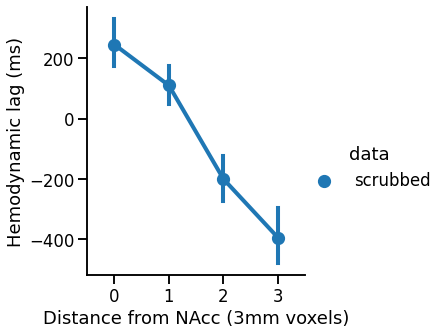

In [321]:
sns.set_context('talk')
sub_df = df[df.data == 'scrubbed']
sub_df.to_csv('./scrubbed_MSC.csv')
sns.catplot(x = 'distance',
             y = 'lag',
             hue = 'data',
              errorbar=('ci', 68),
              dodge = .1,
#               units = 'sub',
            kind = 'point',
             data = sub_df)
sns.despine()
plt.ylabel('Hemodynamic lag (ms)')
plt.xlabel('Distance from NAcc (3mm voxels)')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [306]:
import statsmodels.formula.api as smf

md = smf.mixedlm("lag ~ distance", 
                       df,
                       groups=df["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM  Dependent Variable:  lag        
No. Observations:  672      Method:              REML       
No. Groups:        9        Scale:               682527.3500
Min. group size:   64       Log-Likelihood:      -5469.1586 
Max. group size:   80       Converged:           Yes        
Mean group size:   74.7                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    476.961  142.824  3.340 0.001  197.032  756.890
distance    -264.609   28.505 -9.283 0.000 -320.478 -208.741
Group Var 157920.838  101.960                               
============================================================

"""